<a href="https://colab.research.google.com/github/jianmosier/Data-excavate/blob/master/forth%20card/Task4%E5%BB%BA%E6%A8%A1%E8%B0%83%E5%8F%82.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#四、建模与调参
了解各种模型的评价和调参策略

##4.1学习目标
了解常用的机器学习模型，并掌握机器学习模型的建模与调参流程

##4.2内容介绍
1.线性回归模型：
*   线性回归对于特征的要求；
*   处理长尾分布；
*   理解线性回归模型；
2.模型性能验证：
*   评价函数与目标函数
*   交叉验证方法
*   留一验证方法
*   针对时间序列问题的验证
*   绘制学习率曲线
*   绘制验证曲线
3.嵌入式特征选择：
*   Lasso回归
*   Ridge回归
*   决策树
4.模型对比：
*   常用线性模型
*   常用非线性模型
5.模型调参：
*   贪心调参方法
*   网格调参方法
*   贝叶斯调参方法



















##4.3相关原理介绍与推荐
###4.3.1[线性回归模型](https://zhuanlan.zhihu.com/p/49480391)
###4.3.2[决策树模型](https://zhuanlan.zhihu.com/p/65304798)
###4.3.3[GBDT模型](https://zhuanlan.zhihu.com/p/45145899)
###4.3.4[XGBoost模型](https://zhuanlan.zhihu.com/p/86816771)
###4.3.5[LightGBM模型](https://zhuanlan.zhihu.com/p/86816771)
###4.3.6推荐教材：
《机器学习》
《统计学习方法》
《Python大战机器学习》
《面向机器学习的特征工程》
《数据科学家访谈录》

##4.4代码示例


###4.4.1读取数据

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem/1024/1024+start_mem%1024/1024))
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem/1024/1024+end_mem%1024/1024))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
sample_feature = reduce_mem_usage(pd.read_csv('/content/drive/My Drive/数据挖掘入门/Task3特征工程/data_for_tree.csv'))

Memory usage of dataframe is 59.43 MB
Memory usage after optimization is: 15.86 MB
Decreased by 73.4%


In [0]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

###4.4.2线性回归&五折交叉验证&模拟真实业务情况

In [0]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)  #reset_index(drop=True)保证index连续
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

###4.4.2-1简单建模

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
model = LinearRegression(normalize=True)

In [0]:
model = model.fit(train_X, train_y)

查看训练的线性回归模型的截距（intercept）与权重（coef）

In [0]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

In [0]:
from matplotlib import pyplot as plt

In [0]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果与真实标签的分布差异较大，且部分预测值小于0,说明模型存在问题

The predicted price is obvious different from true price


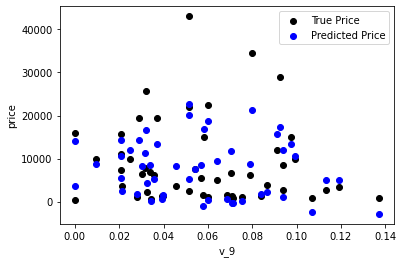

In [14]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

通过作图我们发现数据的标签呈现长尾分布，不利于建模预测。原因是很多模型都假设数据误差项符合正态分布，而长尾分布的数据违背了这一假设。[参考](https://blog.csdn.net/Noob_daniel/article/details/76087829)

It is clear to see the price shows a typical exponential distribution


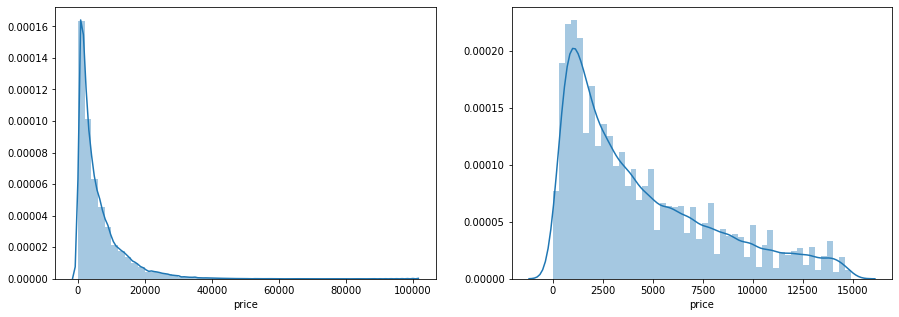

In [15]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

在这里我们对标签进行了log(x+1)变换，使标签贴近于正态分布

In [0]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


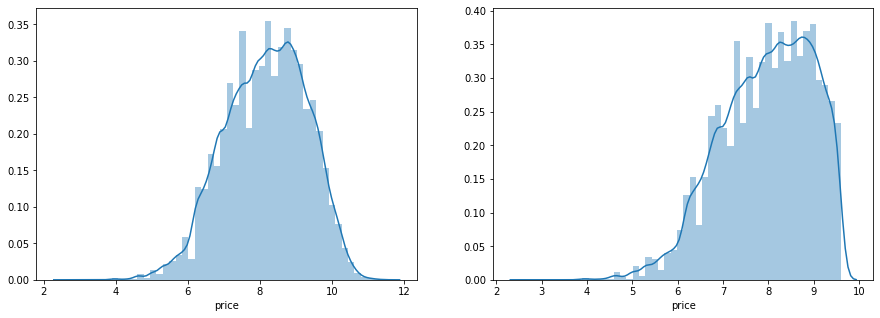

In [17]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [0]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


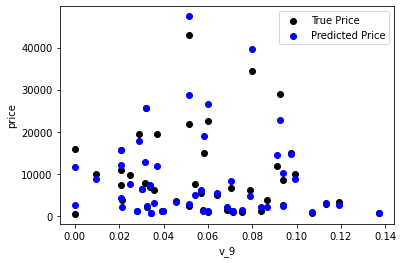

In [19]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

###4.4.2-2五折交叉验证
在使用训练集对参数进行训练的时候，经常发现人们通常会将一整个训练集分为三部分（比如mnist手写训练集）。一般分为，训练集，评估集，测试集这三个部分。这其实是为了保证训练效果而特意设置的。测试集：就是完全不参与训练的效果，仅仅用来观测测试效果的数据。而训练集和评估集牵扯到下面的知识。
在实际的训练中，训练的结果对训练集的拟合程度还是挺好的，但是对于训练集外面的数据拟合程度通常不那么令人满意。因此我们通常不会把所有的数据集都拿来训练，而是分出一部分来对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想称为交叉验证（Cross Validation）。

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [0]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [22]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


使用线性回归模型对，未处理的标签的特征数据进行五折交叉验证

In [24]:
print('AVG:', np.mean(scores))

AVG: 1.3658024027228914


使用线性回归模型，对处理的标签的特征数据进行五折交叉验证

In [25]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


In [26]:
print('AVG:', np.mean(scores))

AVG: 0.19325301545987963


In [27]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


###4.4.2-3模拟真实业务情况
事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，显然不合理。因此，我们还可以采用时间顺序对数据集进行分割。在本例中，我们选择靠前时间的4/5样本当做训练集，靠后时间的1/5当做验证集，最终结果与五折交叉验证差距不大

In [0]:
import datetime

In [0]:
sample_feature = sample_feature.reset_index(drop=True)

In [0]:
split_point = len(sample_feature) // 5 * 4

In [0]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [0]:
model = model.fit(train_X, train_y_ln)

In [33]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667051816913

4.4.2-4 绘制学习率曲线与验证曲线

In [0]:
from sklearn.model_selection import learning_curve, validation_curve

In [0]:
? learning_curve#？表示帮助

In [0]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

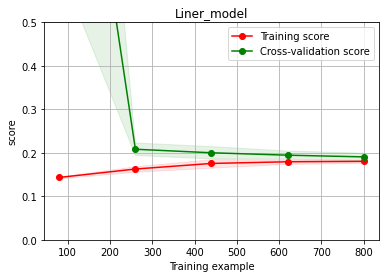

In [39]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

###4.4.3 多种模型对比

In [0]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

4.4.3-1线性模型&嵌入式特征选择
本章节默认，读者已经了解过拟合、模型复杂度、正则化等概念。相关资料参考如下链接：
[过拟合](https://www.zhihu.com/question/32246256/answer/55320482)
[泛化](http://yangyingming.com/article/434/)
[正则化](https://blog.csdn.net/jinping_shi/article/details/52433975)
在过滤式和包裹式特征选择方法中，特征选择过程与学习器训练过程有明显的分别。而嵌入式特征选择在学习器训练过程中自动的进行特征选择。嵌入式选择最常用的是L1正则化与L2正则化。在对线性回归模型加入两种正则化方法后，他们分别变成了岭回归和Lasso回归。

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [0]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [44]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [45]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750745407695362


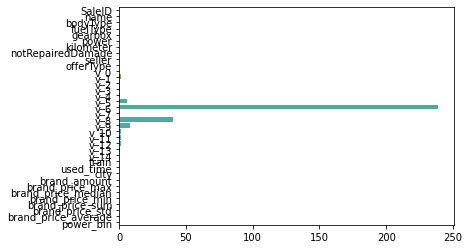

In [46]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移的多一点也不会对结果造成什么影响，专业一点的说法就是【抗干扰能强】

intercept:4.671710782356053


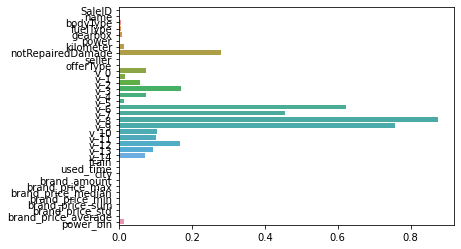

In [47]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。

intercept:8.672182455737993


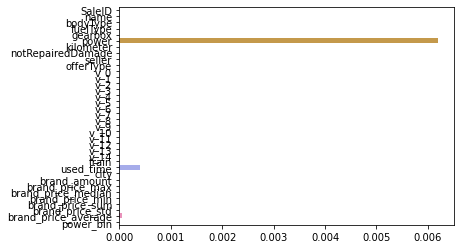

In [48]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的。
####4.4.3-2非线性模型
除了线性模型外，还有许多我们常用的非线性模型如下，在此，选择部分常用模型与线性模型进行效果对比。

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [0]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [52]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [53]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.200636,0.132746,0.168900,462.156857,0.169990,0.141544
cv2,0.193758,0.192194,0.134422,0.171831,403.558654,0.171826,0.145501
cv3,0.194132,0.189167,0.133278,0.170900,408.517769,0.172123,0.143887
cv4,0.191825,0.190679,0.132494,0.169076,154.013002,0.169635,0.142497
cv5,0.195758,0.204235,0.137398,0.174088,365.111787,0.172824,0.144852


可以看到随机森林模型在每一个fold中均取得了更好的效果
###4.4.4模型调参
在此介绍三种常用的调参方法如下：
[贪心算法](https://www.jianshu.com/p/ab89df9759c8)
[网格调参]( https://blog.csdn.net/weixin_43172660/article/details/83032029)
[贝叶斯调参](https://blog.csdn.net/linxid/article/details/81189154)

In [0]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

####4.4.4-1贪心调参

In [0]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

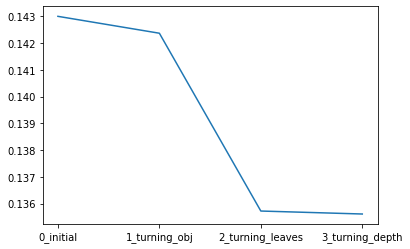

In [57]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

####4.4.4-2 Grid Search 调参

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [60]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [0]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [63]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.137548329347744

####4.4.4-3贝叶斯调参

In [0]:
!pip install bayesian-optimization

上面的安装是必要的，安装bayes_opt

In [0]:
from bayes_opt import BayesianOptimization

In [0]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [0]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [72]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8535   |  87.2     |  82.07    |  23.78    |  0.7435   |
|  2        |  0.8371   |  53.41    |  78.34    |  9.26     |  0.4567   |
|  3        |  0.8677   |  93.01    |  98.0     |  78.62    |  0.9096   |
|  4        |  0.8669   |  73.1     |  88.32    |  71.75    |  0.1614   |
|  5        |  0.8586   |  55.43    |  44.19    |  33.74    |  0.814    |
|  6        |  0.869    |  98.97    |  3.54     |  99.76    |  0.886    |
|  7        |  0.8063   |  2.792    |  4.668    |  96.98    |  0.9239   |
|  8        |  0.8204   |  98.2     |  2.316    |  5.322    |  0.2259   |
|  9        |  0.8693   |  99.91    |  58.22    |  98.47    |  0.4484   |
|  10       |  0.8676   |  93.09    |  95.78    |  81.76    |  0.8446   |
|  11       |  0.866    |  99.08    |  32.03    |  66.95    |  0.8451   |
|  12       |  0.8695   |  72.95    | 

In [73]:
1 - rf_bo.max['target']

0.1305349921734692

总结
在本章，完成了建模与调参的工作，并对模型进行了验证。此外，还采用了一些基本方法来提高预测的精度，提升如下图所示

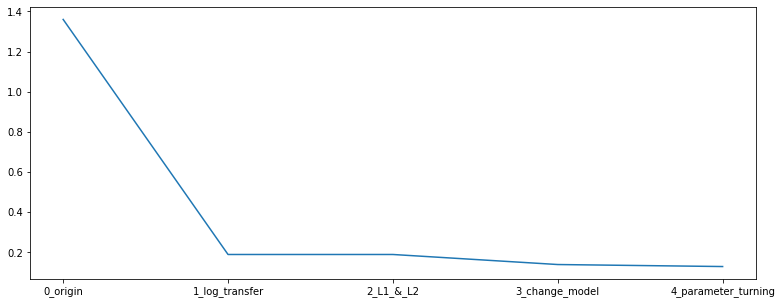

In [74]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])